In [1]:
# 비지도 학습(dtw, cosine, procrustes)으로 유사도 검출하는 코드 (실패)
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('GPU 사용 가능')
else:
    device = 'cpu'
    print('GPU 사용 불가')

GPU 사용 가능


In [292]:
from model.extract_user_dataset import extract_user_dataset

video_path = './video/test_federer.mp4'
#test_dataset = extract_user_dataset(video_path)
import numpy as np
test_dataset = np.load('./video/test_federer.npy')

In [3]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader # Pytorch에서 데이터를 불러오고, 전처리하는 클래스

class ClassificationDataset(Dataset):
    def __init__(self, seq_data):
        self.X = []
        self.y = []
        for dic in seq_data:
            self.X.append(dic['value'])
            self.y.append(dic['key'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
            return len(self.X)

In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader # Pytorch에서 데이터를 불러오고, 전처리하는 클래스

class AnomalyDetectionDataset(Dataset):
    def __init__(self, seq_data):
        self.dataset = []
        for data in seq_data:
            self.dataset.append(data)

    def __getitem__(self, index):
        data = self.dataset[index]
        return torch.Tensor(np.array(data))
        
    def __len__(self):
            return len(self.dataset)

In [5]:
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=100, hidden_size = 172, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=172, hidden_size = 256, num_layers=1, batch_first=True)
        #self.lstm3 = nn.LSTM(input_size=256, hidden_size = 512, num_layers=1, batch_first=True)
        self.dropout1 = nn.Dropout(0.3)
        #self.lstm4 = nn.LSTM(input_size=512, hidden_size = 256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size = 128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size = 64, num_layers=1, batch_first=True)
        self.dropout2 = nn.Dropout(0.3)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size = 32, num_layers=1, batch_first=True)
        self.fc = nn.Linear(32, 7)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        #x, _ = self.lstm3(x)
        x = self.dropout1(x)
        #x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x = self.fc(x[:,-1,:])
        return x

In [6]:
class Encoder(nn.Module):

    def __init__(self, input_size=100, hidden_size=50, num_layers=2):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.3, bidirectional=False)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)  # out: tensor of shape (batch_size, seq_length, hidden_size)

        return (hidden, cell)
    
class Decoder(nn.Module):

    def __init__(self, input_size=100, hidden_size=50, output_size=100, num_layers=2):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                            dropout=0.3, bidirectional=False)

        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        output, (hidden, cell) = self.lstm(x, hidden)  # out: tensor of shape (batch_size, seq_length, hidden_size)
        prediction = self.fc(output)

        return prediction, (hidden, cell)
    
## LSTM Auto Encoder
class LSTMAutoEncoder(nn.Module):

    def __init__(self,
                 input_dim: int,
                 latent_dim: int,
                 sequence_length: int=1,
                 **kwargs) -> None:
        """
        :param input_dim: 변수 Tag 갯수
        :param latent_dim: 최종 압축할 차원 크기
        :param sequence length: sequence 길이
        :param kwargs:
        """

        super(LSTMAutoEncoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.sequence_length = sequence_length

        if "num_layers" in kwargs:
            num_layers = kwargs.pop("num_layers")
        else:
            num_layers = 1

        self.encoder = Encoder(
            input_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )
        self.reconstruct_decoder = Decoder(
            input_size=input_dim,
            output_size=input_dim,
            hidden_size=latent_dim,
            num_layers=num_layers,
        )

    def forward(self, src:torch.Tensor, **kwargs):
        batch_size, sequence_length, var_length = src.size()

        ## Encoder 넣기t
        encoder_hidden = self.encoder(src)
        
        inv_idx = torch.arange(sequence_length - 1, -1, -1).long()
        reconstruct_output = []
        temp_input = torch.zeros((batch_size, 1, var_length), dtype=torch.float).to(src.device)
        hidden = encoder_hidden
        for t in range(sequence_length):
            temp_input, hidden = self.reconstruct_decoder(temp_input, hidden)
            reconstruct_output.append(temp_input)
        reconstruct_output = torch.cat(reconstruct_output, dim=1)[:, inv_idx, :]
        
        return [reconstruct_output, src]

    def loss_function(self,
                      *args,
                      **kwargs) -> dict:
        recons = args[0]
        input = args[1]
        
        ## MSE loss(Mean squared Error)
        loss =F.mse_loss(recons, input)
        return loss

In [166]:
# 모델 세팅
import joblib

classification_model = LSTM_model().to(device)
anomaly_detection_model = LSTMAutoEncoder(input_dim=100, latent_dim=50, sequence_length=60, num_layers=4).to(device)

# 모델 불러오기
classification_model.load_state_dict(torch.load('./model/model_info/classification_model', map_location=device))
anomaly_detection_model.load_state_dict(torch.load('./model/model_info/anomaly_detection_model', map_location=device))
similarity_model = joblib.load('./model/model_info/similarity_model.joblib')

In [293]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

classification_model.eval()
anomaly_detection_model.eval()

test_data = []
classification_data = []
anomaly_detection_data = []

for data in test_dataset:
    test_data.append(data)
    classification_data.append({'key': 8, 'value': data})
    anomaly_detection_data.append(data)

classification_data = ClassificationDataset(classification_data)
classification_data = DataLoader(classification_data)
anomaly_detection_data = AnomalyDetectionDataset(anomaly_detection_data)
anomaly_detection_data = DataLoader(anomaly_detection_data)

In [294]:
# Classification 계산
classification_list = []

for data, label in tqdm(classification_data):
    data = data.to(device)
    with torch.no_grad():
        result = classification_model(data)
        result = F.softmax(result, dim=1)
        out_result, out = torch.max(result, 1)
        if out.item() == 0: 
            classification_list.append(['Forehand', out_result])
        elif out.item() == 1: 
            classification_list.append(['Backhand', out_result])
        elif out.item() == 2: 
            classification_list.append(['Backslice', out_result])
        elif out.item() == 3: 
            classification_list.append(['ForeVolley', out_result])
        elif out.item() == 4: 
            classification_list.append(['BackVolley', out_result])
        elif out.item() == 5: 
            classification_list.append(['Smash', out_result])
        elif out.item() == 6: 
            classification_list.append(['Serve', out_result])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:04<00:00, 489.99it/s]


In [295]:
# data anomaly detection loss 계산하기
anomaly_detection_list = []

with torch.no_grad():
    for _data in tqdm(anomaly_detection_data, desc='Testing'):
        data = _data.to(device)
        predict_values = anomaly_detection_model(data)

        ## MAE(Mean Absolute Error)로 계산
        loss = F.l1_loss(predict_values[0], predict_values[1], reduce=False)
        #loss = loss.sum(dim=2).sum(dim=1).cpu().numpy()
        loss = loss.mean(dim=1).cpu().numpy()
        anomaly_detection_list.append(loss)
anomaly_detection_list = np.concatenate(anomaly_detection_list, axis=0)

Testing:   0%|                                                                                                                                               | 0/2040 [00:00<?, ?it/s]C:\Users\yhjmi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Testing: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:25<00:00, 81.59it/s]


In [296]:
# 비정상 점수 계산

# Reconstruction Error의 평균과 Covarinace 계산
mean = np.mean(anomaly_detection_list, axis=0)
std = np.cov(anomaly_detection_list.T)

class Anomaly_Calculator:
    def __init__(self, mean:np.array, std:np.array):
        assert mean.shape[0] == std.shape[0] and mean.shape[0] == std.shape[1], '평균과 분산의 차원이 똑같아야 합니다.'
        self.mean = mean
        self.std = std
    
    def __call__(self, recons_error:np.array):
        x = (recons_error-self.mean)
        return np.matmul(np.matmul(x, self.std), x.T)

anomaly_calculator = Anomaly_Calculator(mean, std)

anomaly_scores = []
for temp_loss in tqdm(anomaly_detection_list):
    temp_score = anomaly_calculator(temp_loss)
    anomaly_scores.append(temp_score)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2040/2040 [00:00<00:00, 14033.50it/s]


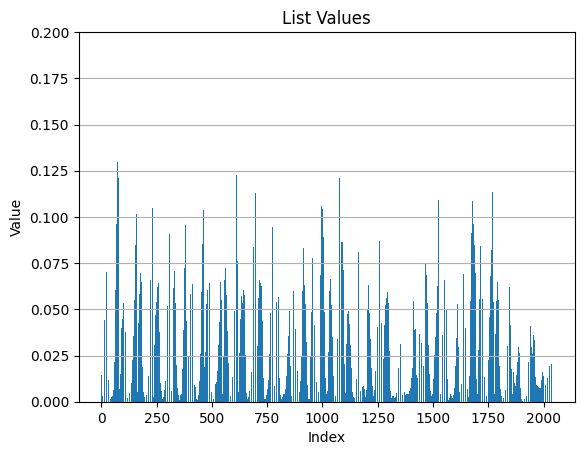

In [297]:
# 비정상 점수 그래프로 표시하기

# x축 인덱스 생성
indices = list(range(len(anomaly_scores)))

# 막대 그래프 그리기
plt.bar(indices, anomaly_scores)
plt.title('List Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True, axis='y')
plt.show()

In [298]:
from sklearn.metrics.pairwise import cosine_similarity
from tslearn.metrics import dtw
from scipy.spatial import procrustes
    
centroids = similarity_model.cluster_centers_

remove_padding_centroids = []

for centroid in centroids:
    remove_padding_centroids.append(np.array([i for i in centroid if i[0] != 0]))

similarity_cos = []
similarity_dtw = []
similarity_procrustes = []

similarity_cos_cluster = []
similarity_dtw_cluster = []
similarity_procrustes_cluster = []

temp_index = 0
for data in test_data:
    distances_dtw = []
    distances_cos = []
    distances_procrustes = []
    # 각 클러스터 중심과의 코사인 거리 계산
    for centroid in remove_padding_centroids:
        distances_dtw.append(dtw(data[:len(centroid)], centroid))
        distances_cos.append((cosine_similarity(np.array(data[:len(centroid)]).flatten().reshape(1, -1), centroid.flatten().reshape(1, -1))[0][0] + 1) / 2)
        _, _, procrustes_value = procrustes(data[:len(centroid)], centroid)
        distances_procrustes.append(1 - procrustes_value)

    closest_cluster = np.argmin(distances_dtw)
    similarity_dtw.append(distances_dtw)
    if closest_cluster == 4 or closest_cluster == 9:
        similarity_dtw_cluster.append('Forehand')
    elif closest_cluster == 2 or closest_cluster == 5:
        similarity_dtw_cluster.append('Backhand')
    elif closest_cluster == 10 or closest_cluster == 12:
        similarity_dtw_cluster.append('Backslice')
    elif closest_cluster == 0 or closest_cluster == 3:
        similarity_dtw_cluster.append('ForeVolley')
    elif closest_cluster == 7 or closest_cluster == 8:
        similarity_dtw_cluster.append('BackVolley')
    elif closest_cluster == 1 or closest_cluster == 13:
        similarity_dtw_cluster.append('Smash')
    elif closest_cluster == 6 or closest_cluster == 11:
        similarity_dtw_cluster.append('Serve')

    closest_cluster = np.argmax(distances_cos)
    similarity_cos.append(distances_cos)
    if closest_cluster == 4 or closest_cluster == 9:
        similarity_cos_cluster.append('Forehand')
    elif closest_cluster == 2 or closest_cluster == 5:
        similarity_cos_cluster.append('Backhand')
    elif closest_cluster == 10 or closest_cluster == 12:
        similarity_cos_cluster.append('Backslice')
    elif closest_cluster == 0 or closest_cluster == 3:
        similarity_cos_cluster.append('ForeVolley')
    elif closest_cluster == 7 or closest_cluster == 8:
        similarity_cos_cluster.append('BackVolley')
    elif closest_cluster == 1 or closest_cluster == 13:
        similarity_cos_cluster.append('Smash')
    elif closest_cluster == 6 or closest_cluster == 11:
        similarity_cos_cluster.append('Serve')

    closest_cluster = np.argmax(distances_procrustes)
    similarity_procrustes.append(distances_procrustes)
    if closest_cluster == 4 or closest_cluster == 9:
        similarity_procrustes_cluster.append('Forehand')
    elif closest_cluster == 2 or closest_cluster == 5:
        similarity_procrustes_cluster.append('Backhand')
    elif closest_cluster == 10 or closest_cluster == 12:
        similarity_procrustes_cluster.append('Backslice')
    elif closest_cluster == 0 or closest_cluster == 3:
        similarity_procrustes_cluster.append('ForeVolley')
    elif closest_cluster == 7 or closest_cluster == 8:
        similarity_procrustes_cluster.append('BackVolley')
    elif closest_cluster == 1 or closest_cluster == 13:
        similarity_procrustes_cluster.append('Smash')
    elif closest_cluster == 6 or closest_cluster == 11:
        similarity_procrustes_cluster.append('Serve')

    if anomaly_scores[temp_index] < 0.0035:
        print(temp_index)
        print(f'{similarity_dtw[-1]}, {similarity_dtw_cluster[-1]}')
        print()
        print(f'{similarity_cos[-1]}, {similarity_cos_cluster[-1]}')
        print()
        print(f'{similarity_procrustes[-1]}, {similarity_procrustes_cluster[-1]}')
        print()
    temp_index += 1

4
[9.703117018783093, 12.350876360340175, 15.134962426688682, 5.0290913044259185, 7.369072893253585, 10.942822595373181, 15.049325632294808], ForeVolley

[0.7628250358647125, 0.7129707017053162, 0.6957727519160254, 0.9130492343518632, 0.8237608725234882, 0.8482355717668854, 0.6942520994576056], ForeVolley

[0.556817960568434, 0.5676368069455242, 0.48541040975799565, 0.545374443299165, 0.6619404670384043, 0.37878414713137465, 0.41313698951939837], Forehand

5
[9.054588931096076, 12.509164058657985, 15.091297940129653, 5.1958615785440525, 7.621102641661273, 10.906903615984081, 14.7577275200379], ForeVolley

[0.7676251102092785, 0.7063516499504526, 0.693407768176095, 0.9076592730688438, 0.8135621534265624, 0.8523812979494388, 0.7008375595457296], ForeVolley

[0.5507037386784832, 0.5350206138284707, 0.4706905895398086, 0.6010114620847868, 0.729646831595456, 0.4166147509689593, 0.39094699125251575], Forehand

35
[8.00152722146413, 10.375953928589785, 10.621025404287149, 6.209706500344326, 9

In [299]:
def cal_similarity(similarity, frame_index, classification_index):
    if classification_index == 'Forehand':
        return similarity[frame_index][0]
        #return max(similarity[frame_index][4], similarity[frame_index][9], similarity[frame_index][3])
    elif classification_index == 'Backhand':
        return similarity[frame_index][1]
        #return max(similarity[frame_index][2], similarity[frame_index][5], similarity[frame_index][7], similarity[frame_index][8])
    elif classification_index == 'Backslice':
        return similarity[frame_index][2]
        #return max(similarity[frame_index][10], similarity[frame_index][12], similarity[frame_index][2], similarity[frame_index][7])
    elif classification_index == 'ForeVolley':
        return similarity[frame_index][3]
        #return max(similarity[frame_index][3], similarity[frame_index][0])
    elif classification_index == 'BackVolley':
        return similarity[frame_index][4]
        #return max(similarity[frame_index][7], similarity[frame_index][8])
    elif classification_index == 'Smash':
        return similarity[frame_index][5]
        #return max(similarity[frame_index][1], similarity[frame_index][13])
    elif classification_index == 'Serve':
        return similarity[frame_index][6]
        #return max(similarity[frame_index][6], similarity[frame_index][11], similarity[frame_index][1])

In [300]:
# frame 분할 있음, cosine similarity
import cv2
out_img_list = []
out_index = 0
frame_index = 0
frame_cnt = 0
is_detection = False
threshold = 0.0035
result_video = cv2.VideoCapture(video_path)
width = int(result_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(result_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

while result_video.isOpened():
    # Read a frame from the video
    success, frame = result_video.read()

    if success:
        if out_index < len(anomaly_scores):
            if anomaly_scores[out_index] < threshold:
                if frame_cnt == 0:
                    frame_index = out_index
                    is_detection = True
        if is_detection:
            if frame_cnt < 60:
                info = f'detection! -> {classification_list[frame_index][0]} : {cal_similarity(similarity_cos, frame_index, classification_list[frame_index][0]):.1%}, {similarity_cos_cluster[frame_index]}'
                #info = f'detection! -> {classification_list[frame_index][0]} : {similarity[frame_index]:.1%}'
                #info = f'detection! -> {classification_list[frame_index][0]} : {similarity_dtw_cluster[frame_index]}, {similarity_cos_cluster[frame_index]}, {similarity_procrustes_cluster[frame_index]} : {similarity_dtw[frame_index]:.1%}, {similarity_cos[frame_index]:.1%}, {similarity_procrustes[frame_index]:.1%}'
                cv2.putText(frame, info, (45, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), thickness=3)
                frame_cnt += 1
            else:
                frame_cnt = 0
                is_detection = False
        out_img_list.append(frame)
        out_index += 1
    else:
        break

result_video.release()

In [301]:
filename = './result_video_cos.mp4'
fourcc =  cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, (width, height), isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()

In [302]:
# frame 분할 있음, procrustes similarity
import cv2
out_img_list = []
out_index = 0
frame_index = 0
frame_cnt = 0
is_detection = False
threshold = 0.0035
result_video = cv2.VideoCapture(video_path)
width = int(result_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(result_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

while result_video.isOpened():
    # Read a frame from the video
    success, frame = result_video.read()

    if success:
        if out_index < len(anomaly_scores):
            if anomaly_scores[out_index] < threshold:
                if frame_cnt == 0:
                    frame_index = out_index
                    is_detection = True
        if is_detection:
            if frame_cnt < 60:
                info = f'detection! -> {classification_list[frame_index][0]} : {cal_similarity(similarity_procrustes, frame_index, classification_list[frame_index][0]):.1%}, {similarity_procrustes_cluster[frame_index]}'
                #info = f'detection! -> {classification_list[frame_index][0]} : {similarity[frame_index]:.1%}'
                #info = f'detection! -> {classification_list[frame_index][0]} : {similarity_dtw_cluster[frame_index]}, {similarity_cos_cluster[frame_index]}, {similarity_procrustes_cluster[frame_index]} : {similarity_dtw[frame_index]:.1%}, {similarity_cos[frame_index]:.1%}, {similarity_procrustes[frame_index]:.1%}'
                cv2.putText(frame, info, (45, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), thickness=3)
                frame_cnt += 1
            else:
                frame_cnt = 0
                is_detection = False
        out_img_list.append(frame)
        out_index += 1
    else:
        break

result_video.release()

In [303]:
filename = './result_video_procrustes.mp4'
fourcc =  cv2.VideoWriter_fourcc(*'DIVX')
fps = 30
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, (width, height), isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()

In [ ]:
# frame 분할 없음
import cv2
out_img_list = []
out_index = 0
threshold = 0.004
result_video = cv2.VideoCapture('./video/test_video.mp4')
width = int(result_video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(result_video.get(cv2.CAP_PROP_FRAME_HEIGHT))

while result_video.isOpened():
    # Read a frame from the video
    success, frame = result_video.read()

    if success:
        if out_index < len(anomaly_scores):
            if anomaly_scores[out_index] < threshold:
                info = f'detection! -> {classification_list[out_index][0]}, {similarity_cluster[out_index]} : {similarity[out_index]}%'
                cv2.putText(frame, info, (45, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), thickness=3)
        out_img_list.append(frame)
        out_index = out_index + 1
    else:
        break

result_video.release()